<a href="https://colab.research.google.com/github/matthewkmkim/YOBO/blob/main/QAC_YOLO_FER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv3: Real Time Detection (You Only Look Once)





In [1]:
!git clone https://github.com/matthewkmkim/YOBO.git

Cloning into 'YOBO'...
remote: Enumerating objects: 1430, done.
remote: Total 1430 (delta 0), reused 0 (delta 0), pack-reused 1430
Receiving objects: 100% (1430/1430), 676.07 MiB | 37.60 MiB/s, done.
Resolving deltas: 100% (248/248), done.
Checking out files: 100% (1398/1398), done.


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8260453175086941890, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14281870390576173860
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.8889204380000137
GPU (s):
0.0387749870000107
GPU speedup over CPU: 74x


In [5]:
import os

In [6]:
os.rename('/content/YOBO/darknet_gc', '/content/YOBO/darknet')

In [7]:
!ls '/content/YOBO/'

darknet


In [8]:
%cd '/content/YOBO/darknet'

/content/YOBO/darknet


In [9]:
!make clean

rm -rf ./obj/gemm.o ./obj/utils.o ./obj/cuda.o ./obj/deconvolutional_layer.o ./obj/convolutional_layer.o ./obj/list.o ./obj/image.o ./obj/activations.o ./obj/im2col.o ./obj/col2im.o ./obj/blas.o ./obj/crop_layer.o ./obj/dropout_layer.o ./obj/maxpool_layer.o ./obj/softmax_layer.o ./obj/data.o ./obj/matrix.o ./obj/network.o ./obj/connected_layer.o ./obj/cost_layer.o ./obj/parser.o ./obj/option_list.o ./obj/detection_layer.o ./obj/route_layer.o ./obj/upsample_layer.o ./obj/box.o ./obj/normalization_layer.o ./obj/avgpool_layer.o ./obj/layer.o ./obj/local_layer.o ./obj/shortcut_layer.o ./obj/logistic_layer.o ./obj/activation_layer.o ./obj/rnn_layer.o ./obj/gru_layer.o ./obj/crnn_layer.o ./obj/demo.o ./obj/batchnorm_layer.o ./obj/region_layer.o ./obj/reorg_layer.o ./obj/tree.o ./obj/lstm_layer.o ./obj/l2norm_layer.o ./obj/yolo_layer.o ./obj/iseg_layer.o ./obj/image_opencv.o libdarknet.so libdarknet.a darknet ./obj/captcha.o ./obj/lsd.o ./obj/super.o ./obj/art.o ./obj/tag.o ./obj/cifar.o ./ob

In [10]:
!make

mkdir -p results
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/gemm.c -o obj/gemm.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/utils.c -o obj/utils.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/cuda.c -o obj/cuda.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/convolutional_layer.c -o obj/convolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/list.c -o obj/list.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/image.c -o obj/image.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-

In [11]:
cd ..

/content/YOBO


In [12]:
ls

darknet/


## Run from the backup checkpoint
Weights at 3400th batch

### Output on Colab

In [13]:
# !darknet/darknet detector train darknet/custom_data/detector.data darknet/custom_data/cfg/yolov3-tiny.cfg darknet/backup/yolov3-tiny.backup -gpu 0

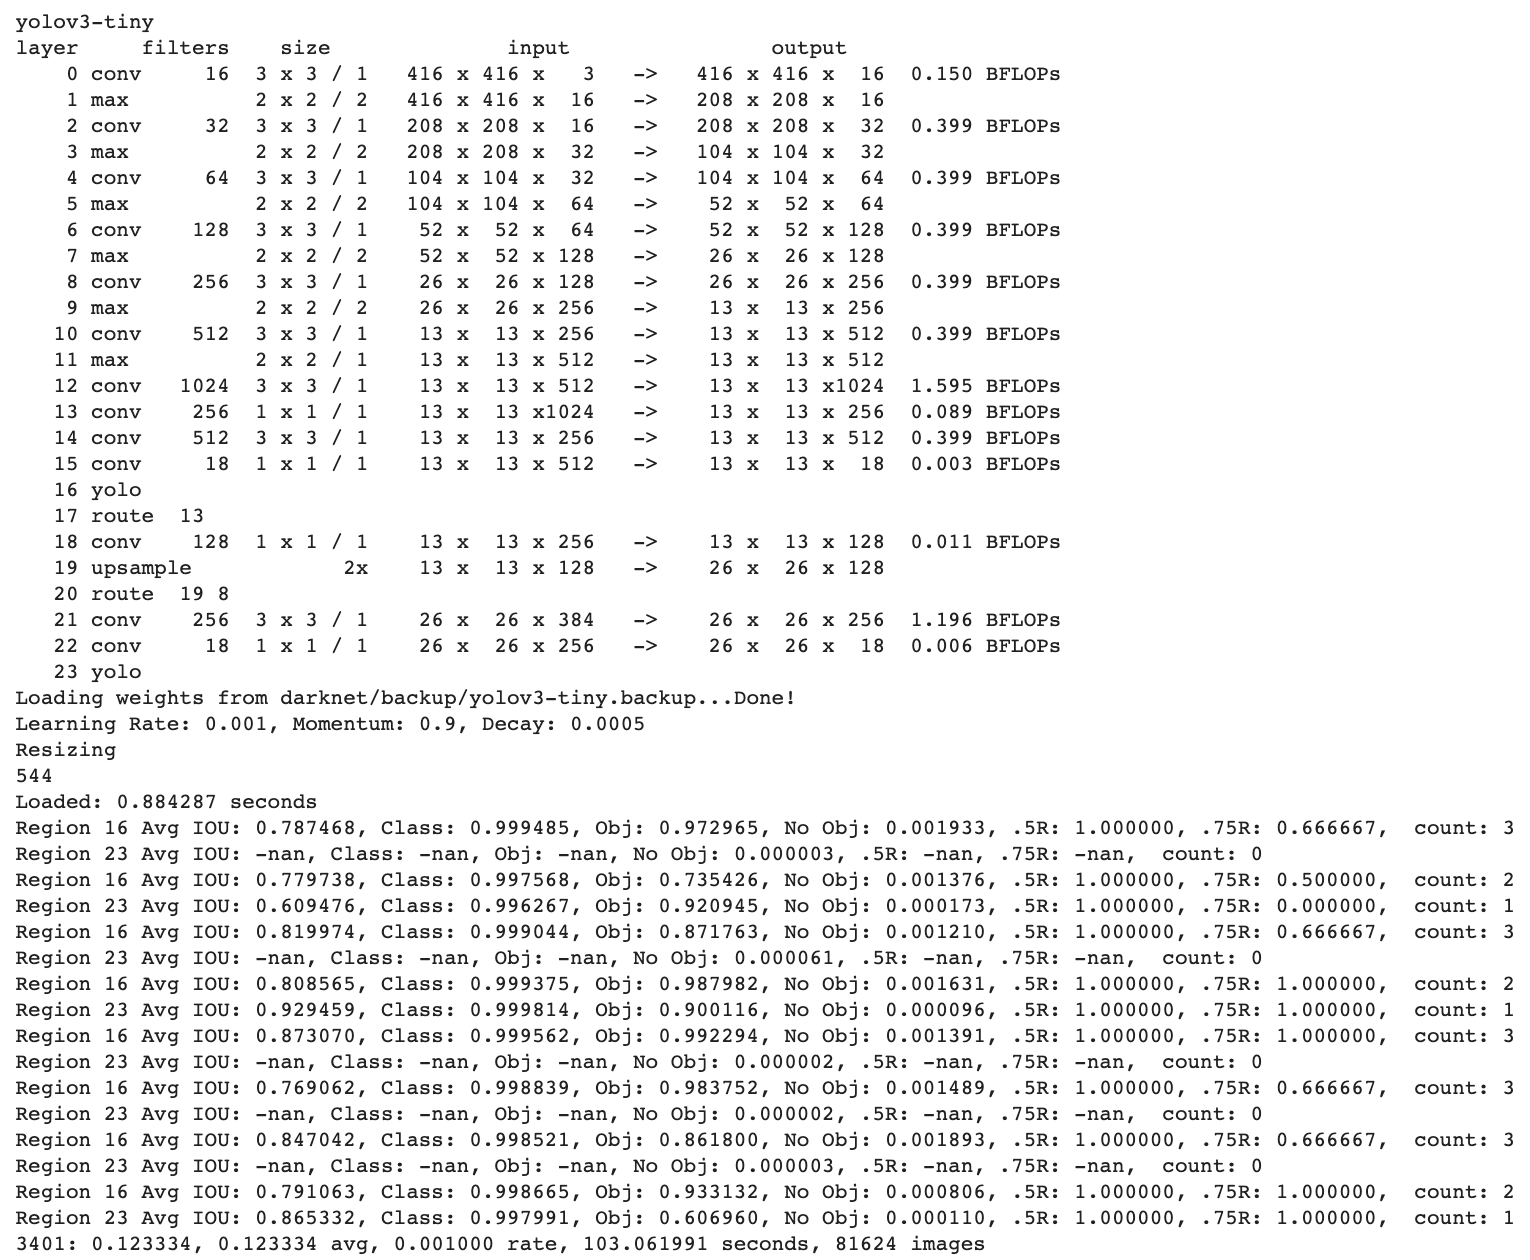

### Output on Computer

**We decided to train on Matthew Kim's computer because as you can tell from the two images, even with the GPU connected on Colab, Matthew's computer was still faster**


In [14]:
# ./darknet detector train custom_data/detector.data custom_data/cfg/yolov3-tiny.cfg backup/yolov3-tiny.backup -gpu 0

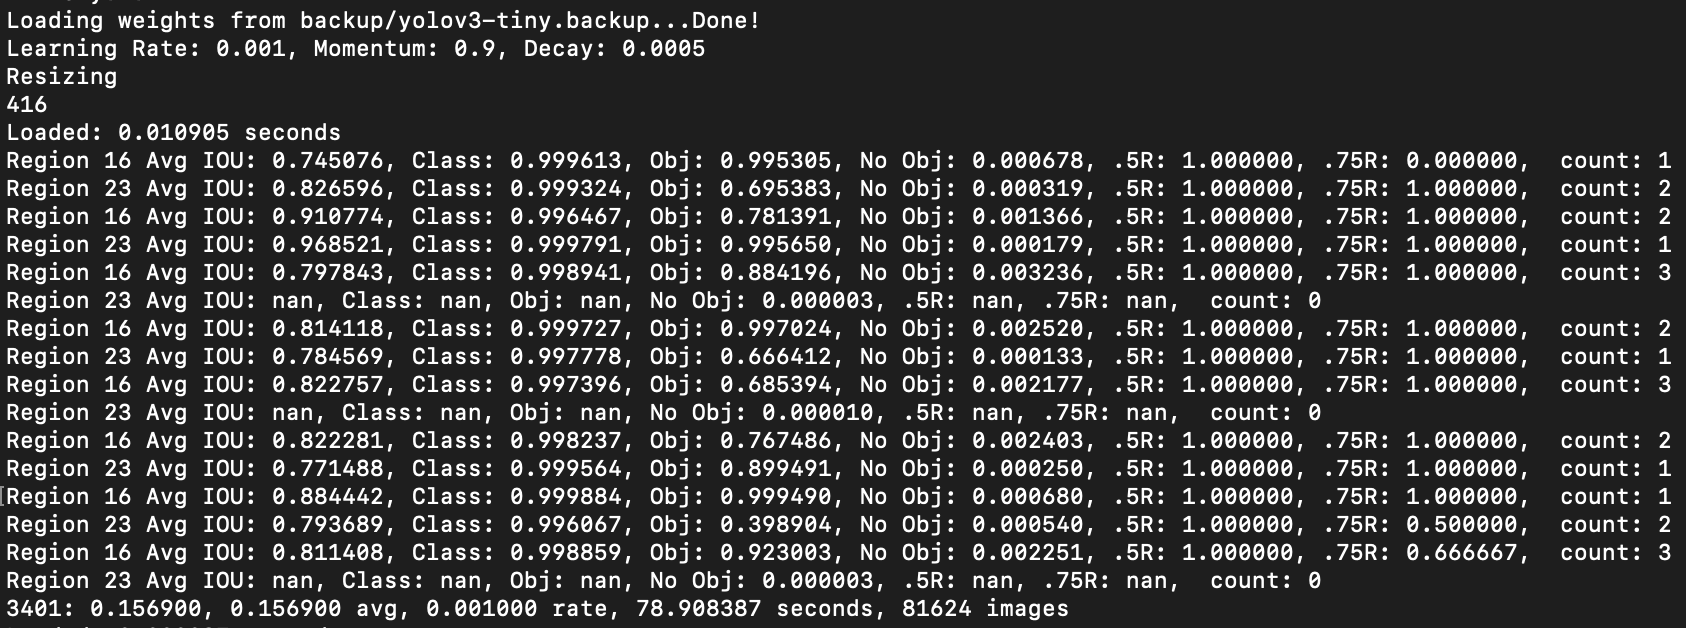

## Test the model on a single image


### Output on Colab

Will save it as prediction.jpg in yolo_custom_modal_Training/darknet drirectory of colab

In [15]:
# !darknet/darknet detector test darknet/custom_data/detector.data darknet/custom_data/cfg/yolov3-tiny.cfg darknet/backup/yolov3-tiny_3400.weights darknet/custom_data/images/frame153.jpg

This did not end up working for some reason

### Output on a computer
Will save it as prediction.jpg in ....darknet drirectory of computer

In [16]:
# ./darknet detector test custom_data/detector.data custom_data/cfg/yolov3-tiny.cfg backup/yolov3-tiny_3400.weights custom_data/images/frame153.jpg

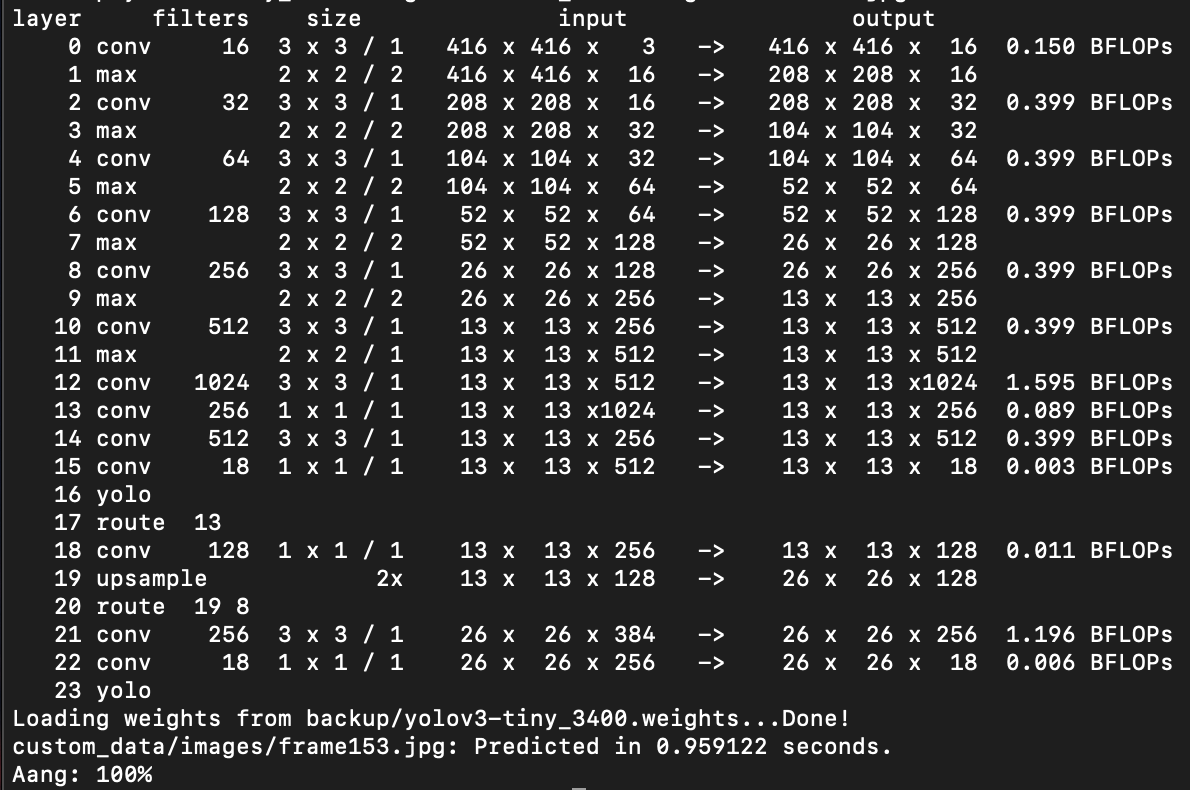

## Test on all test images and see its output in results_test.txt

### Output on Colab

In [17]:
# !darknet/darknet detector test darknet/custom_data/detector.data darknet/custom_data/cfg/yolov3-tiny.cfg darknet/backup/yolov3-tiny_3400.weights < darknet/custom_data/test.txt > darknet/custom_data/results_test.txt

This did not work either for some reason

### Output on Computer

In [18]:
# ./darknet detector test custom_data/detector.data custom_data/cfg/yolov3-tiny.cfg backup/yolov3-tiny_3400.weights < custom_data/test.txt > custom_data/results_test.txt

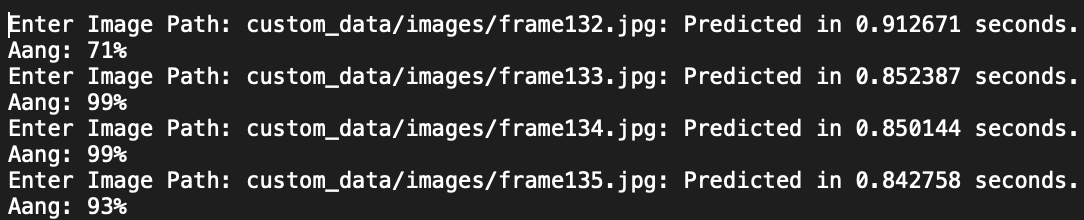

# Face Detection for Aang using Haar, 

In [19]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

import dlib
from imutils import face_utils

In [20]:
file_list =[]
for i in os.listdir('/content/YOBO/darknet/custom_data/images'):
  if '.png' in i or 'jpg' in i:
    file_list.append(i)
file_list

['frame53.jpg',
 'frame16.jpg',
 'frame31.jpg',
 'frame55.jpg',
 'frame124.jpg',
 'frame23.jpg',
 'frame13.jpg',
 'frame54.jpg',
 'frame37.jpg',
 'frame62.jpg',
 'frame141.jpg',
 'frame59.jpg',
 'frame101.jpg',
 'frame96.jpg',
 'frame165.jpg',
 'frame73.jpg',
 'frame58.jpg',
 'frame68.jpg',
 'frame39.jpg',
 'frame119.jpg',
 'frame24.jpg',
 'frame28.jpg',
 'frame33.jpg',
 'frame78.jpg',
 'frame134.jpg',
 'frame15.jpg',
 'frame75.jpg',
 'frame136.jpg',
 'frame127.jpg',
 'frame48.jpg',
 'frame98.jpg',
 'frame44.jpg',
 'frame7.jpg',
 'frame82.jpg',
 'frame155.jpg',
 'frame143.jpg',
 'frame112.jpg',
 'frame35.jpg',
 'frame138.jpg',
 'frame85.jpg',
 'frame63.jpg',
 'frame0.jpg',
 'frame162.jpg',
 'frame108.jpg',
 'frame117.jpg',
 'frame50.jpg',
 'frame95.jpg',
 'frame1.jpg',
 'frame105.jpg',
 'frame6.jpg',
 'frame3.jpg',
 'frame29.jpg',
 'frame70.jpg',
 'frame97.jpg',
 'frame77.jpg',
 'frame36.jpg',
 'frame11.jpg',
 'frame118.jpg',
 'frame84.jpg',
 'frame60.jpg',
 'frame57.jpg',
 'frame99.jp

In [21]:
#Function for returning images in color with OpenCV
def convertToRGB(img): 
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## Haar Cascade Classifier

In [22]:
!wget --no-check-certificate https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml \
    -O haarcascade_frontalface_default.xml

--2021-05-21 02:06:19--  https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.02s   

2021-05-21 02:06:20 (47.9 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [23]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

def hcfd(img):
  img_haar = img.copy()
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #opencv face detector expects gray images
  faces = face_cascade.detectMultiScale(gray, 1.3, 3)

  for (x,y,w,h) in faces: #go over list of faces and draw them as rectangles on original colored image
    img_haar = cv2.rectangle(img_haar,(x,y),(x+w,y+h),(0,0,255),2) 
    
  plt.figure(figsize=(12,8))
  plt.imshow(convertToRGB(img_haar))
  
  return len(faces)

## HoG Face Detector in Dlib

In [24]:
face_detect = dlib.get_frontal_face_detector()

def hoG(img):
  img_hog = img.copy()
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #opencv face detector expects gray images
  # Step 2
  im = np.float32(gray) / 255.0
  # Calculate gradient 
  #CV_32F is float - the pixel can have any value between 0-1.0
  #𝚔𝚜𝚒𝚣𝚎 = 𝟷, the 3×1 or 1×3 kernel is used
  gx = cv2.Sobel(im, cv2.CV_32F, 1, 0, ksize=1) 
  gy = cv2.Sobel(im, cv2.CV_32F, 0, 1, ksize=1)
  mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
  # The 2 in the second argument indicates that we should upsample the image
  # 2 time.  This will make everything bigger and allow us to detect more
  # faces.
  rects = face_detect(gray, 1)

  for (i, rect) in enumerate(rects):
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(img_hog, (x, y), (x + w, y + h), (255, 255, 255), 2)
    
  plt.figure(figsize=(12,8))
  plt.imshow(convertToRGB(img_hog))

  return len(rects)


# Deep Learning based Face Detector in Dlib 

In [25]:
!wget https://github.com/davisking/dlib-models/raw/master/mmod_human_face_detector.dat.bz2

--2021-05-21 02:06:21--  https://github.com/davisking/dlib-models/raw/master/mmod_human_face_detector.dat.bz2
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/davisking/dlib-models/master/mmod_human_face_detector.dat.bz2 [following]
--2021-05-21 02:06:21--  https://raw.githubusercontent.com/davisking/dlib-models/master/mmod_human_face_detector.dat.bz2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694687 (678K) [application/octet-stream]
Saving to: ‘mmod_human_face_detector.dat.bz2’

mmod_human_face_det 100%[===================>] 678.41K  --.-KB/s    in 0.01s   

2021-05-21 02:06:21 (52.5 MB/s) 

In [26]:
!bunzip2 'mmod_human_face_detector.dat.bz2' # decompressed the .bz2 file

In [27]:
dnnFaceDetector = dlib.cnn_face_detection_model_v1('mmod_human_face_detector.dat')

def deep_learning(img):
  img_dp = img.copy()
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rects = dnnFaceDetector(gray, 2) 
  for (i, rect) in enumerate(rects):
    x1 = rect.rect.left()
    y1 = rect.rect.top()
    x2 = rect.rect.right()
    y2 = rect.rect.bottom()
    # Rectangle around the face
    cv2.rectangle(img_dp, (x1, y1), (x2, y2), (0, 255, 0), 2)

  plt.figure(figsize=(12,8))
  plt.imshow(cv2.cvtColor(img_dp, cv2.COLOR_BGR2RGB))

  return len(rects)

In [28]:
import pandas as pd

In [29]:
df = pd.DataFrame({'fname' : file_list, 'Haar_faces' : 0, 'HoG_faces' : 0, 'Dlib_faces' : 0 })
df

,fname,Haar_faces,HoG_faces,Dlib_faces
0,frame53.jpg,0,0,0
1,frame16.jpg,0,0,0
2,frame31.jpg,0,0,0
3,frame55.jpg,0,0,0
4,frame124.jpg,0,0,0
...,...,...,...,...
149,frame80.jpg,0,0,0
150,frame8.jpg,0,0,0
151,frame19.jpg,0,0,0
152,frame34.jpg,0,0,0


In [ ]:
for index, filename in enumerate(file_list):
  if '.png' in filename or 'jpg' in filename:
    img = cv2.imread('/content/YOBO/darknet/custom_data/images/' + filename)
    df.loc[index,'Haar_faces'] = hcfd(img)
    df.loc[index,'HoG_faces'] = hoG(img)
    df.loc[index,'Dlib_faces'] = deep_learning(img)
    print("On Image: " + str(index) + "/154")

In [31]:
df

,fname,Haar_faces,HoG_faces,Dlib_faces
0,frame53.jpg,2,1,1
1,frame16.jpg,2,3,1
2,frame31.jpg,0,0,0
3,frame55.jpg,0,0,0
4,frame124.jpg,0,0,0
...,...,...,...,...
149,frame80.jpg,1,1,1
150,frame8.jpg,0,0,1
151,frame19.jpg,1,1,2
152,frame34.jpg,0,0,0


In [32]:
df = df.sort_values('fname')
df.reset_index(drop=True)

,fname,Haar_faces,HoG_faces,Dlib_faces
0,frame0.jpg,0,0,0
1,frame1.jpg,0,0,1
2,frame10.jpg,1,0,0
3,frame100.jpg,0,1,2
4,frame101.jpg,0,0,0
...,...,...,...,...
149,frame95.jpg,0,1,0
150,frame96.jpg,0,0,1
151,frame97.jpg,0,0,0
152,frame98.jpg,0,0,0


In [33]:
df.sum()

fname         frame0.jpgframe1.jpgframe10.jpgframe100.jpgfra...
Haar_faces                                                   54
HoG_faces                                                    56
Dlib_faces                                                   83
dtype: object

# FER (EMOTION DETECTION)

## Installation

In [34]:
!pip install fer

     |████████████████████████████████| 819kB 28.7MB/s 
     |████████████████████████████████| 2.3MB 45.5MB/s 


In [35]:
from fer import FER
import pprint
import os

Instructions for updating:
non-resource variables are not supported in the long term


## Example on a single image

In [36]:
#Assign the image a variable
img = cv2.imread("/content/YOBO/darknet/custom_data/images/frame1.jpg")

In [37]:
#The FER model
detector = FER()

#Detect the emotions and asign it to result.
result = detector.detect_emotions(img)

#The reuslt is a JSON object
pprint.pprint(result)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


[{'box': (355, 96, 437, 437),
  'emotions': {'angry': 0.01,
               'disgust': 0.0,
               'fear': 0.85,
               'happy': 0.0,
               'neutral': 0.0,
               'sad': 0.13,
               'surprise': 0.01}}]


In [38]:
#Prints only the TOP emotion and its score
emotion, score = detector.top_emotion(img) # Example 'happy', 0.99

print(emotion, score)

fear 0.85


In [39]:
#Faces by default are detected using OpenCV's Haar Cascade classifier. 

#To use the more accurate MTCNN network, add the parameter:
detector = FER(mtcnn=True)


result = detector.detect_emotions(img)
pprint.pprint(result)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


[{'box': (399, 122, 397, 397),
  'emotions': {'angry': 0.02,
               'disgust': 0.0,
               'fear': 0.82,
               'happy': 0.0,
               'neutral': 0.0,
               'sad': 0.09,
               'surprise': 0.08}}]


## Time to see the results of the detector on 154 Images

In [40]:
#Get the filenames of our 154 images and put them in a list for easy access
file_list =[]
for i in os.listdir('/content/YOBO/darknet/custom_data/images'):
  if '.png' in i or 'jpg' in i:
    file_list.append(i)
file_list

['frame53.jpg',
 'frame16.jpg',
 'frame31.jpg',
 'frame55.jpg',
 'frame124.jpg',
 'frame23.jpg',
 'frame13.jpg',
 'frame54.jpg',
 'frame37.jpg',
 'frame62.jpg',
 'frame141.jpg',
 'frame59.jpg',
 'frame101.jpg',
 'frame96.jpg',
 'frame165.jpg',
 'frame73.jpg',
 'frame58.jpg',
 'frame68.jpg',
 'frame39.jpg',
 'frame119.jpg',
 'frame24.jpg',
 'frame28.jpg',
 'frame33.jpg',
 'frame78.jpg',
 'frame134.jpg',
 'frame15.jpg',
 'frame75.jpg',
 'frame136.jpg',
 'frame127.jpg',
 'frame48.jpg',
 'frame98.jpg',
 'frame44.jpg',
 'frame7.jpg',
 'frame82.jpg',
 'frame155.jpg',
 'frame143.jpg',
 'frame112.jpg',
 'frame35.jpg',
 'frame138.jpg',
 'frame85.jpg',
 'frame63.jpg',
 'frame0.jpg',
 'frame162.jpg',
 'frame108.jpg',
 'frame117.jpg',
 'frame50.jpg',
 'frame95.jpg',
 'frame1.jpg',
 'frame105.jpg',
 'frame6.jpg',
 'frame3.jpg',
 'frame29.jpg',
 'frame70.jpg',
 'frame97.jpg',
 'frame77.jpg',
 'frame36.jpg',
 'frame11.jpg',
 'frame118.jpg',
 'frame84.jpg',
 'frame60.jpg',
 'frame57.jpg',
 'frame99.jp

## FER Model with the MTCNN Network

In [41]:
detector = FER(mtcnn=True)

#Function to print out images with the bouding boxes around faces and emotions detected using the MTCNN network
def emotion_mtcnn(filename):

  #Load in the Imaage
  image = cv2.imread('/content/YOBO/darknet/custom_data/images/' + filename)
  # Result is a JSON object with all the bounding boxes (faces) detected and the emotions of each bound box
  result = detector.detect_emotions(image)

  #If no bounding box was made then make a red line indicating that no face was dectected
  if not result:
     cv2.line(image, (0, 0), (1300, 700), (0, 20, 200), 10)
     plt.figure(figsize=(12,12))
     return "No Emotion Found in Image:", filename, plt.imshow(convertToRGB(image))

  #Else we draw the bounding box where the "face" was detected and write the percentiles of the emotion classified
  else:
    bounding_box = result[0]["box"]
    emotions = result[0]["emotions"]

    cv2.rectangle(
        image,
        (bounding_box[0], bounding_box[1]),
        (bounding_box[0] + bounding_box[2], bounding_box[1] + bounding_box[3]),
        (0, 155, 255),
        2,
    )

    for idx, (emotion, score) in enumerate(emotions.items()):
        color = (211, 211, 211) if score < 0.01 else (0, 255, 0)
        emotion_score = "{}: {}".format(
            emotion, "{:.2f}".format(score) if score > 0.01 else ""
        )
        cv2.putText(
            image,
            emotion_score,
            (bounding_box[0], bounding_box[1] + bounding_box[3] + 30 + idx * 15),
            cv2.FONT_HERSHEY_SIMPLEX,
            .5,
            color,
            1,
            cv2.LINE_AA,
        )

    #Return the image
    plt.figure(figsize=(12,12))
    return plt.imshow(convertToRGB(image)) 
    return True

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
i = 0
for index, filename in enumerate(file_list):
  print("On Image: " + str(index) + "/154")
  #emotion_mtcnn(filename)
  if emotion_mtcnn(filename) == True:
    i += 1
print(i)

#50 Faces detected and labeled withe emotions

## FER Model with OpenCV's Haar Cascade Classifier

In [43]:
detector = FER()
#Function to print out images with the bouding boxes around faces and emotions detected using OpenCV's Haar Cascade classifier. 
def emotion_haar(filename):
  #Load in the Imaage
  image = cv2.imread('/content/YOBO/darknet/custom_data/images/' + filename)
  # Result is a JSON object with all the bounding boxes (faces) detected and the emotions of each bound box
  result = detector.detect_emotions(image)

  #If no bounding box was made then make a red line indicating that no face was dectected
  if not result:
     cv2.line(image, (0, 0), (1300, 700), (0, 20, 200), 10)
     plt.figure(figsize=(12,12))
     return "No Emotion Found in Image:", filename, plt.imshow(convertToRGB(image))

  #Else we draw the bounding box where the "face" was detected and write the percentiles of the emotion classified
  else:
    bounding_box = result[0]["box"]
    emotions = result[0]["emotions"]

    cv2.rectangle(
        image,
        (bounding_box[0], bounding_box[1]),
        (bounding_box[0] + bounding_box[2], bounding_box[1] + bounding_box[3]),
        (0, 155, 255),
        2,
    )

    for idx, (emotion, score) in enumerate(emotions.items()):
        color = (211, 211, 211) if score < 0.01 else (0, 255, 0)
        emotion_score = "{}: {}".format(
            emotion, "{:.2f}".format(score) if score > 0.01 else ""
        )
        cv2.putText(
            image,
            emotion_score,
            (bounding_box[0], bounding_box[1] + bounding_box[3] + 30 + idx * 15),
            cv2.FONT_HERSHEY_SIMPLEX,
            .5,
            color,
            1,
            cv2.LINE_AA,
        )

    #Return the image
    plt.figure(figsize=(12,12))
    return plt.imshow(convertToRGB(image)) 
    return True

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
j = 0
for index, filename in enumerate(file_list):
  print("On Image: " + str(index) + "/154")
  emotion_haar(filename)
  if emotion_haar(filename) == True:
    j += 1
print(j)

#67 Faces detected and labeled with emotion